In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, linear_model 
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
%matplotlib inline

C:\Users\amand\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Read in csv file

In [2]:
data = pd.read_csv("NFLPlaybyPlay2015.csv", dtype={'DefTwoPoint': str}, na_values=['NA'])
data.head()

,Unnamed: 0,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,...,Accepted.Penalty,PenalizedTeam,PenaltyType,PenalizedPlayer,Penalty.Yards,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,Season
0,36.0,9/10/2015,2.015091e+09,1.0,1.0,NaN,15:00,15.0,3600.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2015.0
1,51.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,15:00,15.0,3600.0,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2015.0
2,72.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,14:21,15.0,3561.0,39.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2015.0
3,101.0,9/10/2015,2.015091e+09,1.0,1.0,2.0,14:04,15.0,3544.0,17.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2015.0
4,122.0,9/10/2015,2.015091e+09,1.0,1.0,1.0,13:26,14.0,3506.0,38.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2015.0


Create dummy variables for categorical values

In [3]:
df = data.copy()

#Extra Point
df['ExPointAborted'] = pd.get_dummies(df['ExPointResult'])["Aborted"]
df['ExPointMade']= pd.get_dummies(df['ExPointResult'])["Made"]
df['ExPointMissed']= pd.get_dummies(df['ExPointResult'])["Missed"]

#Two Point Conv
df['TwoPointSuc']= pd.get_dummies(df['TwoPointConv'])["Success"]
df['TwoPointFail']= pd.get_dummies(df['TwoPointConv'])["Failure"]

#Defense Two Point
df['DefTwoPointSuc']= pd.get_dummies(df['DefTwoPoint'])["Success"]
df['DefTwoPointFail']= pd.get_dummies(df['DefTwoPoint'])["Failure"]

# Punt Result
df['PuntResultClean']= pd.get_dummies(df['PuntResult'])["Clean"]
df['PuntResultBlocked']= pd.get_dummies(df['PuntResult'])["Blocked"]

#Play Type
df['KickoffPlay']= pd.get_dummies(df['PlayType'])["Kickoff"]
df['RunPlay']= pd.get_dummies(df['PlayType'])["Run"]
df['PassPlay']= pd.get_dummies(df['PlayType'])["Pass"]
df['SackPlay']= pd.get_dummies(df['PlayType'])["Sack"]
df['NoPlay']= pd.get_dummies(df['PlayType'])["No Play"]
df['FieldGoalPlay']= pd.get_dummies(df['PlayType'])["Field Goal"]
df['PuntPlay']= pd.get_dummies(df['PlayType'])["Punt"]
df['ExtraPointPlay']= pd.get_dummies(df['PlayType'])["Extra Point"]
df['QBKneelPlay']= pd.get_dummies(df['PlayType'])["QB Kneel"]
df['SpikePlay']= pd.get_dummies(df['PlayType'])["Spike"]
df['OnsideKickPlay']= pd.get_dummies(df['PlayType'])["Onside Kick"]

#Pass Outcome
df['CompletedPass']= pd.get_dummies(df['PassOutcome'])["Complete"]
df['IncompletePass']= pd.get_dummies(df['PassOutcome'])["Incomplete Pass"]

#Side of Field
df["OffenseSide"] = (df["SideofField"] == df["posteam"])

#Pass Length
df["ShortPass"] = pd.get_dummies(df['PassLength'])["Short"]
df["DeepPass"] = pd.get_dummies(df['PassLength'])["Deep"]

#Pass Location
df["LeftPass"]= pd.get_dummies(df['PassLocation'])["left"]
df["MiddlePass"]= pd.get_dummies(df['PassLocation'])["middle"]
df["RightPass"]= pd.get_dummies(df['PassLocation'])["right"]

#Run Location
df["LeftRun"]= pd.get_dummies(df['RunLocation'])["left"]
df["MiddleRun"]= pd.get_dummies(df['RunLocation'])["middle"]
df["RightRun"]= pd.get_dummies(df['RunLocation'])["right"]

#Run Gap
df["RunGapEnd"]= pd.get_dummies(df['RunGap'])["end"]
df["RunGapGuard"]= pd.get_dummies(df['RunGap'])["guard"]
df["RunGapTackle"]= pd.get_dummies(df['RunGap'])["tackle"]

#Return Result
df["ReturnResultTD"]= pd.get_dummies(df['ReturnResult'])["Touchdown"]
df["ReturnResultTouch"]= pd.get_dummies(df['ReturnResult'])["Touchback"]

#Offense Fumble Recovery
df["OffFumbleRecover"] = (df["RecFumbTeam"] == df["posteam"])

#Challenge Result
df["ChalOverturned"]= pd.get_dummies(df['ChalReplayResult'])["Reversed"]
df["ChalAccept"]= pd.get_dummies(df['ChalReplayResult'])["Upheld"]

#Penalty
df["OffPenalty"] = (df["PenalizedTeam"] == df["posteam"])

Drop rows without relevent data (i.e. posteam, defensive team, etc)

In [4]:
df = df.drop(df[df['PlayType'] == "Quarter End"].index)
df = df.drop(df[df['PlayType'] == "Two Minute Warning"].index)
df = df.drop(df[df['PlayType'] == "Timeout"].index)
df = df.drop(df[df['PlayType'] == "End of Game"].index)
df = df.drop(df[df['PlayType'] == "Half End"].index)

Check for Null values

In [5]:
df[df["posteam"].isnull()]

,Unnamed: 0,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,...,RightRun,RunGapEnd,RunGapGuard,RunGapTackle,ReturnResultTD,ReturnResultTouch,OffFumbleRecover,ChalOverturned,ChalAccept,OffPenalty


Isolate needed columns

In [6]:
df = df[['posteam', 'DefensiveTeam', 'PosTeamScore', 'ScoreDiff', 'Accepted.Penalty', 'Challenge.Replay',
         "ChalOverturned", "ChalAccept", 'OffPenalty', 
         'DefTeamScore', 'Yards.Gained', 'sp', 'Touchdown', 'Safety','ExPointAborted', 'ExPointMade', 
         'ExPointMissed', 'TwoPointSuc', 'TwoPointFail', 'DefTwoPointSuc', 'DefTwoPointFail', 
         'PuntResultClean', 'PuntResultBlocked',  'KickoffPlay', 'RunPlay', 'PassPlay', 'SackPlay', 
         'NoPlay', 'IncompletePass', 'CompletedPass', 'FieldGoalPlay', 'PuntPlay', 'ExtraPointPlay', 
         'ydsnet', "ShortPass", "DeepPass", 'QBKneelPlay', 'SpikePlay', 'OnsideKickPlay', 
         'PassAttempt', 'OffenseSide', "LeftPass", "MiddlePass", "RightPass", 'Reception', 
         "InterceptionThrown", "LeftRun", "MiddleRun", "RightRun", "RunGapEnd", "RunGapGuard", 
         "RunGapTackle", "ReturnResultTD", "ReturnResultTouch", "Fumble", ]]

DataFrame with only required data

In [7]:
df.head()

,posteam,DefensiveTeam,PosTeamScore,ScoreDiff,Accepted.Penalty,Challenge.Replay,ChalOverturned,ChalAccept,OffPenalty,DefTeamScore,...,InterceptionThrown,LeftRun,MiddleRun,RightRun,RunGapEnd,RunGapGuard,RunGapTackle,ReturnResultTD,ReturnResultTouch,Fumble
0,PIT,NE,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,PIT,NE,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,PIT,NE,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PIT,NE,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,PIT,NE,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cluster teams

Groupby Teams

In [8]:
new_df = df.groupby(df["posteam"]).sum()

new_df.head()

,PosTeamScore,ScoreDiff,Accepted.Penalty,Challenge.Replay,ChalOverturned,ChalAccept,OffPenalty,DefTeamScore,Yards.Gained,sp,...,InterceptionThrown,LeftRun,MiddleRun,RightRun,RunGapEnd,RunGapGuard,RunGapTackle,ReturnResultTD,ReturnResultTouch,Fumble
posteam,,,,,,,,,,,,,,,,,,,,,
ARI,19791.0,6444.0,114.0,13.0,6.0,7.0,50.0,13347.0,7924.0,128.0,...,14.0,134.0,146.0,141.0,88.0,50.0,145.0,2.0,46.0,21.0
ATL,12326.0,-2723.0,103.0,11.0,4.0,7.0,53.0,15049.0,7306.0,96.0,...,18.0,182.0,38.0,179.0,193.0,85.0,83.0,3.0,52.0,28.0
BAL,13053.0,-5292.0,100.0,10.0,5.0,5.0,57.0,18345.0,7063.0,94.0,...,21.0,154.0,70.0,152.0,30.0,143.0,133.0,5.0,59.0,12.0
BUF,13866.0,-2526.0,119.0,15.0,5.0,10.0,82.0,16392.0,7236.0,101.0,...,9.0,186.0,128.0,176.0,164.0,93.0,108.0,2.0,38.0,23.0
CAR,21001.0,8479.0,106.0,20.0,8.0,12.0,52.0,12522.0,6790.0,141.0,...,11.0,176.0,146.0,179.0,147.0,112.0,99.0,3.0,51.0,15.0


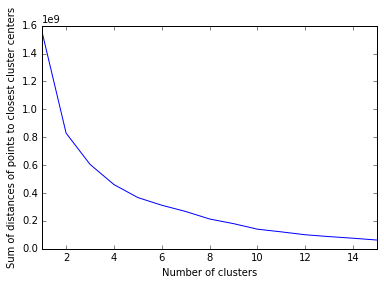

In [9]:
X= new_df

sum_of_distances = {}
for num_clusters in range(1,16):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)
    sum_of_distances[num_clusters] = kmeans.inertia_
ax = Series(sum_of_distances).sort_index().plot()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Sum of distances of points to closest cluster centers')


k_means = KMeans(init='k-means++', n_clusters=5, n_init=10, random_state = 42)
k_means.fit(X)

# Get cluster assignment labels
labels = k_means.labels_
# Format results as a DataFrame
results = pd.DataFrame([X.index,labels]).T

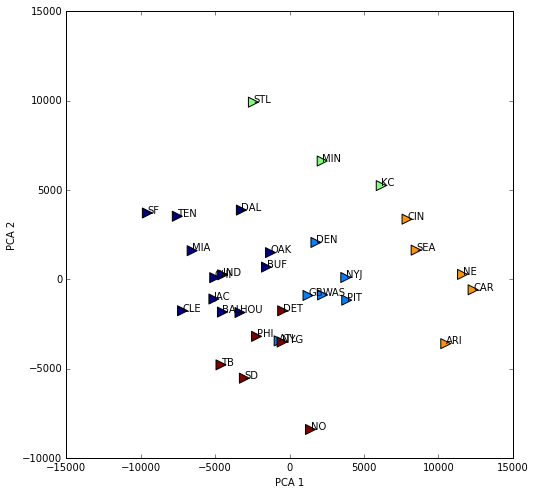

In [10]:
pca_2 = PCA(2)

plot_columns = pca_2.fit_transform(X)

# Plot teams based on two dimensions, and shade by cluster label
plt.figure(figsize=(8,8))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], s=100, c=k_means.labels_, marker= ">")

labels = ['{}'.format(i) for i in results[0]]

for label, x, y in zip(labels, plot_columns[:,0], plot_columns[:,1]):
    plt.annotate(label, xy = (x, y))

In [11]:
(pd.Series(pca_2.components_[0], index=X.columns).sort_values())[-1:]

ScoreDiff    0.801337
dtype: float64

In [12]:
print X["ScoreDiff"].sort_values()[-5:]

posteam
CIN    5355.0
SEA    5594.0
ARI    6444.0
NE     7993.0
CAR    8479.0
Name: ScoreDiff, dtype: float64


Now remove points from DataFrame and try again

In [13]:
new_X = new_df
new_X = new_X.drop('PosTeamScore', 1)
new_X = new_X.drop('ScoreDiff', 1)
new_X = new_X.drop('DefTeamScore', 1)
new_X.head()

,Accepted.Penalty,Challenge.Replay,ChalOverturned,ChalAccept,OffPenalty,Yards.Gained,sp,Touchdown,Safety,ExPointAborted,...,InterceptionThrown,LeftRun,MiddleRun,RightRun,RunGapEnd,RunGapGuard,RunGapTackle,ReturnResultTD,ReturnResultTouch,Fumble
posteam,,,,,,,,,,,,,,,,,,,,,
ARI,114.0,13.0,6.0,7.0,50.0,7924.0,128.0,56.0,0.0,0.0,...,14.0,134.0,146.0,141.0,88.0,50.0,145.0,2.0,46.0,21.0
ATL,103.0,11.0,4.0,7.0,53.0,7306.0,96.0,40.0,0.0,0.0,...,18.0,182.0,38.0,179.0,193.0,85.0,83.0,3.0,52.0,28.0
BAL,100.0,10.0,5.0,5.0,57.0,7063.0,94.0,35.0,0.0,0.0,...,21.0,154.0,70.0,152.0,30.0,143.0,133.0,5.0,59.0,12.0
BUF,119.0,15.0,5.0,10.0,82.0,7236.0,101.0,45.0,0.0,0.0,...,9.0,186.0,128.0,176.0,164.0,93.0,108.0,2.0,38.0,23.0
CAR,106.0,20.0,8.0,12.0,52.0,6790.0,141.0,57.0,1.0,1.0,...,11.0,176.0,146.0,179.0,147.0,112.0,99.0,3.0,51.0,15.0


## Cluster teams with new parameters

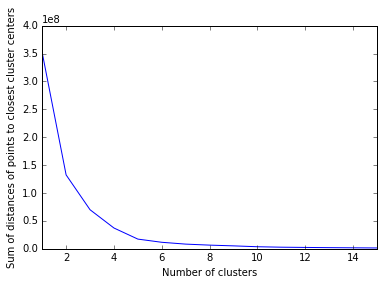

In [14]:
sum_of_distances = {}

for num_clusters in range(1,16):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(new_X)
    sum_of_distances[num_clusters] = kmeans.inertia_
ax = Series(sum_of_distances).sort_index().plot()
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Sum of distances of points to closest cluster centers')

new_k_means = KMeans(init='k-means++', n_clusters = 5, n_init=1000, random_state = 42)
new_k_means.fit(new_X)

# Get cluster assignment labels
new_labels = new_k_means.labels_
# Format results as a DataFrame
new_results = pd.DataFrame([new_X.index,labels]).T

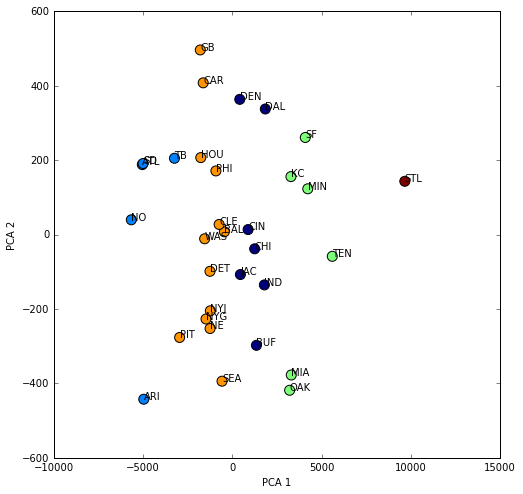

In [15]:
pca_2 = PCA(2)

plot_columns = pca_2.fit_transform(new_X)

# Plot teams based on two dimensions, and shade by cluster label
plt.figure(figsize=(8,8))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], s=100, c=new_labels)

labels = ['{}'.format(i) for i in new_results[0]]

for label, x, y in zip(labels, plot_columns[:,0], plot_columns[:,1]):
    plt.annotate(label, xy = (x, y))

In [16]:
(pd.Series(pca_2.components_[0,:], index=new_X.columns).sort_values())[:1]

ydsnet   -0.995782
dtype: float64

In [17]:
print new_X["ydsnet"].sort_values()[:1]

posteam
STL    26209.0
Name: ydsnet, dtype: float64


In [18]:
print new_X["ydsnet"].sort_values()[-5:]

posteam
TB     39065.0
ARI    40719.0
SD     40807.0
ATL    40851.0
NO     41450.0
Name: ydsnet, dtype: float64


## Try to predict wins per team

Add column that incorporates the wins for each team

In [19]:
wins = [13, 8, 5, 8, 15, 6, 12, 3, 4, 12, 7, 10, 9, 8, 5, 11, 6, 11, 12, 7, 6, 10, 7, 7, 10, 4, 10, 5, 7, 6, 3, 9]
new_df["Wins"] = wins
new_df.Wins.head()

posteam
ARI    13
ATL     8
BAL     5
BUF     8
CAR    15
Name: Wins, dtype: int64

Run Lasso, Lasso with cross-validation, Ridge, and Linear Regressions

In [20]:
X = new_df[new_df.columns[0:16]].values
y = new_df.Wins.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)
n_folds = 5
k_fold = cross_validation.KFold(len(X_train), n_folds) 
lasso_alphas =  10**np.linspace(10,-2,100)*0.5
lasso_avg_rmse = {}

for alpha in lasso_alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=10000000)
    avg_mse = 0
    for k, (train, test) in enumerate(k_fold):
        lasso.fit(X_train[train], y_train[train])
        avg_mse = avg_mse + mean_squared_error(y_train[test], lasso.predict(X_train[test])) 
    lasso_avg_rmse[alpha] = avg_mse / n_folds
best_alpha_lasso = min(lasso_avg_rmse, key=lasso_avg_rmse.get)

In [21]:
ridge_alphas =  10**np.linspace(10,-2,100)*0.5
ridge_avg_rmse = {}

for alpha in ridge_alphas:
    ridge = linear_model.Ridge(alpha=alpha)
    avg_mse = 0
    for k, (train, test) in enumerate(k_fold):
        ridge.fit(X_train[train], y_train[train])
        avg_mse = avg_mse + mean_squared_error(y_train[test], ridge.predict(X_train[test])) 
    ridge_avg_rmse[alpha] = avg_mse / n_folds
best_alpha_ridge = min(ridge_avg_rmse, key=ridge_avg_rmse.get)

In [22]:
linear_clf = linear_model.LinearRegression()
ridge_clf = linear_model.Ridge(alpha=best_alpha_ridge)
lasso_clf = linear_model.Lasso(alpha=best_alpha_lasso)

def fit_reg(model, name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(pred, y_test)
    print("MSE for {0}: {1}".format(name, mse))

fit_reg(linear_clf, "linear")
fit_reg(ridge_clf, "ridge")
fit_reg(lasso_clf, "lasso")

MSE for linear: 3.80429486701
MSE for ridge: 0.649521654288
MSE for lasso: 0.809948403495


In [23]:
lassocv = LassoCV(cv=10, max_iter=10000)
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [24]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print ("MSE for lasso with CV alpha: {}".format(mean_squared_error(y_test, lasso.predict(X_test))))

MSE for lasso with CV alpha: 0.804847358847


In [25]:
lasso_coef_non_zero = np.array([1 if val != 0 else 0 for (var, val) in zip(data.columns, lasso.coef_)], 
                               dtype=bool)
X_train_nonzero = X_train[:,lasso_coef_non_zero]
X_test_nonzero = X_test[:, lasso_coef_non_zero]
linear_clf.fit(X_train_nonzero, y_train)
pred_y = linear_clf.predict(X_test_nonzero)
print ("Linear w/ only non-zeros MSE: {}".format(mean_squared_error(pred_y, y_test)))

Linear w/ only non-zeros MSE: 0.756675579578
